In [ ]:
# === 1. Game State Logic ===
from copy import deepcopy
import pandas as pd
from collections import Counter
import os
import numpy as np
from multiprocessing import Pool

import math
import time
import random
import matplotlib.pyplot as plt



# Define the number of rows and columns for the game board
NUM_ROWS = 6
NUM_COLS = 7

class State:
    """
    Represents the state of the Connect Four game, including the game board, 
    available moves, current player, and winner status.
    """
    def __init__(self):
        # Initialize the game board as a 2D list filled with zeros (empty slots)
        self.board = [[0]*NUM_COLS for _ in range(NUM_ROWS)]
        # Track the current height of each column to determine where the next piece will land
        self.column_heights = [NUM_ROWS - 1] * NUM_COLS
        # List of available columns where a move can be made
        self.available_moves = list(range(7))
        # Player 1 starts the game
        self.player = 1
        # -1 indicates that the game is still ongoing, 0 indicates a draw
        self.winner = -1

    def check_line(self, n, player, values):
        """
        Check if a line contains the specified number of pieces (n) for a player.
        Also considers potential winning or strategic lines.
        Args:
            n (int): The number of pieces to check for (3 or 4).
            player (int): The player number (1 or 2).
            values (list): A list of values in the line being checked.
        Returns:
            bool: True if the line meets the specified condition, False otherwise.
        """
        num_pieces = sum(val == player for val in values)
        if n == 4:
            return num_pieces == 4
        if n == 3:
            return num_pieces == 3 and values.count(0) == 1

    def count_lines(self, n, player):
        """
        Count the number of lines with n pieces for the specified player.
        Args:
            n (int): Number of pieces in the line (3 or 4).
            player (int): Player number (1 or 2).
        Returns:
            int: Number of lines meeting the criteria.
        """
        num_lines = 0
        for row in range(NUM_ROWS):
            for col in range(NUM_COLS):
                if col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row][col+i] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and self.check_line(n, player, [self.board[row+i][col] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row+i][col+i] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and col > 2 and self.check_line(n, player, [self.board[row+i][col-i] for i in range(4)]):
                    num_lines += 1
        return num_lines

    def move(self, column):
        """
        Simulate a move in the game by dropping a piece into a specified column.
        Args:
            column (int): The column where the piece is to be dropped.
        Returns:
            State: A new game state reflecting the move.
        """
        
    
        state_copy = deepcopy(self)
        height = state_copy.column_heights[column]

        # Tried to debug why 3 entries in log after game finishes
        # print(f"Before move: {state_copy.board}")

        state_copy.board[height][column] = self.player
        if height == 0:
            state_copy.available_moves.remove(column)
        else:
            state_copy.column_heights[column] = height - 1
        state_copy.update_winner()
        state_copy.player = 3 - self.player

        
        # Tried to debug why 3 entries in log after game finishes
        # print(f"After move: {state_copy.board}")
        return state_copy

    def update_winner(self):
        if self.count_lines(4, 1) > 0:
            self.winner = 1
        elif self.count_lines(4, 2) > 0:
            self.winner = 2
        elif not self.available_moves:
            self.winner = 0

def column_features(state: State, col: int):
    """
    Features for dropping in column `col` from `state`:
      f0 = immediate win (1) or not (0)
      f1 = blocks opponent’s immediate win (1) or not (0)
      f2 = you get exactly 3 in a row (1) or not (0)
      f3 = opponent would get 3 in a row next if you DON’T play here
      f4 = is center column? (1 if col==3 else 0)
    """
    # simulate your move
    s2 = deepcopy(state).move(col)
    # immediate win?
    f0 = 1 if s2.winner == state.player else 0

    # blocks opponent win?
    f1 = 0
    if f0 == 0:  # no need if you already win
        for c2 in s2.available_moves:
            if s2.move(c2).winner == (3 - state.player):
                f1 = 1
                break

    # your 3-in-a-row count after playing
    f2 = 1 if state.count_lines(3, state.player) < s2.count_lines(3, state.player) else 0

    # opponent threat if you don’t play here
    f3 = 0
    # simulate opponent turn on original state
    for c2 in state.available_moves:
        if deepcopy(state).move(c2).winner == (3 - state.player):
            f3 = 1
            break

    # center bias
    f4 = 1 if col == NUM_COLS // 2 else 0

    return [f0, f1, f2, f3, f4]

def build_feature_dataset(match_data):
    rows = []
    # for each logged (state, move) record
    for idx, rec in match_data.iterrows():
        # reconstruct state.board, state.player from rec['cell_0'..'cell_41'], rec['player']
        state = State()
        flat = [rec[f'cell_{i}'] for i in range(42)]
        for i, val in enumerate(flat):
            r, c = divmod(i, NUM_COLS)
            state.board[r][c] = val
        state.player = rec['player']
        # compute features for each legal move
        feats = []
        for col in state.available_moves:
            feats += column_features(state, col)
        # label is which index among available_moves was chosen
        label = state.available_moves.index(rec['mtcarlomove'])
        rows.append((feats, label))
    # DataFrame of shape (n_samples, 5*#legal_moves) but since #legal varies, you can pad illegal moves with -1 features and label=col index
    # For simplicity, only consider moves always 7 columns: for illegal moves features are all 0.
    X, y = [], []
    for rec in rows:
        feat_vec, lbl = rec
        # pad to length 5*7
        if len(feat_vec) < 5*7:
            feat_vec += [0] * (5*7 - len(feat_vec))
        X.append(feat_vec)
        y.append(lbl)
    return pd.DataFrame(X, columns=[f'f{i}' for i in range(5*7)]), pd.Series(y)


In [ ]:
# === 2. Game Interface ===
def display_board(board):
    print("\n  1 2 3 4 5 6 7")
    print(" ---------------")
    for row in board:
        print("|", end="")
        for cell in row:
            print(" ".join("X" if cell == 1 else "O" if cell == 2 else " "), end="|")
        print()
    print(" ---------------")

def print_welcome():
    print("\n===== CONNECT 4 =====")
    print("1. Player vs Player")
    print("2. Player vs Computer")
    print("3. Computer vs Computer")
    print("4. Exit")
    print("====================")

# === Ensemble Training ===
def train_ensemble(match_data, n_trees: int = 5, max_depth: int = 5):
    X, y = build_feature_dataset(match_data)
    ensemble = []
    N = len(X)
    for _ in range(n_trees):
        idx = np.random.choice(N, N, replace=True)
        Xt, yt = X.iloc[idx], y.iloc[idx]
        tree = ID3DecisionTree()
        tree.fit(Xt, yt, max_depth=max_depth)
        ensemble.append(tree)
    return ensemble

# === Ensemble Move Executor ===
def make_ensemble_ai(trees_list):
    def inner(game: ConnectFourGame):
        st = game.state
        feat = []
        for col in range(NUM_COLS):
            if col in st.available_moves:
                feat += column_features(st, col)
            else:
                feat += [0]*5
        row = pd.Series(feat, index=[f'f{i}' for i in range(5*NUM_COLS)])

        votes = [t.predict_one(row) for t in trees_list]
        try:
            best = Counter(votes).most_common(1)[0][0]
            # Garantir que o índice votado esteja no range de `available_moves`
            if 0 <= best < len(st.available_moves):
                return st.available_moves[best]
            else:
                raise ValueError(f"Voted move index {best} is invalid for available moves {st.available_moves}")
        except Exception as e:
            print(f"⚠️ Ensemble fallback due to error: {e}")
            return random.choice(st.available_moves)
    return inner


In [ ]:
# === 3. Learning from Logs ===

class DecisionNode:
    """
    Represents a node in the decision tree, either a decision node with children 
    or a leaf node with a label.
    """
    def __init__(self, feature=None, children=None, label=None):
        self.feature = feature
        self.children = children if children is not None else {}
        self.label = label

    def is_leaf(self):
        return self.label is not None

class ID3DecisionTree:
    """
    Implementation of the ID3 Decision Tree algorithm, utilizing entropy and information gain.
    """
    def __init__(self):
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series, max_depth=None):
        """
        Train the ID3 Decision Tree using the training data.
        Args:
            X (pd.DataFrame): The feature matrix.
            y (pd.Series): The target labels (moves).
            max_depth (int, optional): Maximum depth of the tree. Default is None.
        """
        data = X.copy()
        data['label'] = y
        self.tree = self._id3(data, X.columns, depth=0, max_depth=max_depth)

    def _entropy(self, labels):
        counts = Counter(labels)
        total = len(labels)
        entropy = 0
        for count in counts.values():
            probability = count / total
            entropy -= probability * math.log2(probability)
        return entropy

    def _information_gain(self, data, feature, target_attribute='label'):
        total_entropy = self._entropy(data[target_attribute])
        values = data[feature].unique()
        weighted_entropy = 0
        for value in values:
            subset = data[data[feature] == value]
            weighted_entropy += (len(subset) / len(data)) * self._entropy(subset[target_attribute])
        return total_entropy - weighted_entropy

    def _id3(self, data, features, depth=0, max_depth=None):
        labels = data['label']
        if len(set(labels)) == 1:
            return DecisionNode(label=labels.iloc[0])
        if len(features) == 0 or (max_depth is not None and depth >= max_depth):
            return DecisionNode(label=labels.mode()[0])

        gains = [(feature, self._information_gain(data, feature)) for feature in features]
        best_feature, _ = max(gains, key=lambda item: item[1])
        node = DecisionNode(feature=best_feature)

        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]
            if subset.empty:
                node.children[value] = DecisionNode(label=labels.mode()[0])
            else:
                remaining_features = features.drop(best_feature)
                node.children[value] = self._id3(subset, remaining_features, depth + 1, max_depth)
        return node

    def predict_one(self, example, node=None):
        if node is None:
            node = self.tree
        if node.is_leaf():
            return node.label
        feature_value = example[node.feature]
        child = node.children.get(feature_value)
        if child is None:
            return None
        return self.predict_one(example, child)

    def predict(self, X: pd.DataFrame):
        return X.apply(lambda row: self.predict_one(row), axis=1)

# === Initial Safe Training for Player 1 & Player 2 ===
learned_tree_p1 = None
learned_tree_p2 = None
def trainnn():
    try:
        md = pd.read_csv("match_log.csv")
        md = md[md['mtcarlomove'].notnull()]
        md.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
        # split by player
        data1 = md[md['player']==1]
        data2 = md[md['player']==2]
        if not data1.empty:
            global learned_trees_p1
            learned_trees_p1 = train_ensemble(data1, n_trees=5, max_depth=5)
        if not data2.empty:
            global learned_trees_p2
            learned_trees_p2 = train_ensemble(data2, n_trees=5, max_depth=5)
    except FileNotFoundError:
        print("🔸 No match_log.csv found; skipping training.")




# === Saving Logs in CSV file ===
def save_match_log(game_history, winner, file_path="match_log.csv"):
    logs = []
    for state, best_move in game_history:
        flat_board = sum(state.board, [])
        entry = {f'cell_{i}': val for i, val in enumerate(flat_board)}
        entry['player'] = state.player
        entry['mtcarlomove'] = best_move
        entry['winner'] = winner
        logs.append(entry)

    df = pd.DataFrame(logs)
    header_needed = not os.path.exists(file_path) or os.stat(file_path).st_size == 0
    df.to_csv(file_path, mode='a', header=header_needed, index=False)


⚠️ Overlap between training and validation: 0 identical examples
Depth 1: Val Accuracy = 0.200
Depth 2: Val Accuracy = 0.244
Depth 3: Val Accuracy = 0.178
Depth 4: Val Accuracy = 0.267
Depth 5: Val Accuracy = 0.289
Depth 6: Val Accuracy = 0.267
Depth 7: Val Accuracy = 0.356
Depth 8: Val Accuracy = 0.356
Depth 9: Val Accuracy = 0.378
✅ Melhor profundidade: 9 com acurácia de 0.378


In [ ]:
# === 4. Game Controller Class ===
class ConnectFourGame:
    """
    Class that manages the flow of a Connect Four game, including logging states, managing AI players, and running multiple matches.
    """
    def __init__(self, player_1_ai, player_2_ai):
        self.state = State()
        self.player_1_ai = player_1_ai
        self.player_2_ai = player_2_ai
        self.match_log = []  # List of (state, best_move) tuples

    def record_play(self, state, move):
        """Record a (state, move) pair for training."""
        self.match_log.append((deepcopy(state), move))

    def save_match_log(self, filename="match_log.csv"):
        if not self.match_log:
            return
        save_match_log(self.match_log, winner=self.state.winner, file_path=filename)
        self.match_log = []

    def start(self, log_moves: bool = False):
        self.state = State()
        self.match_log = []
        start_time = time.time()
        while self.state.winner == -1:
            current_state = deepcopy(self.state)

            if self.state.player == 1:
                move = self.player_1_ai(self)
            else:
                move = self.player_2_ai(self)

            self.record_play(current_state, move)
            self.state = self.state.move(move)

            if log_moves:
                display_board(self.state.board)

        # Final message
        if self.state.winner == 0:
            print("End of game! Draw! %s seconds" % int(time.time() - start_time))
        else:
            print(f"End of game! Player {self.state.winner} wins in %s seconds!" % int(time.time() - start_time))

        # Save logs in format (state, move)
        self.save_match_log()

    def run_n_matches(self, n, max_time=3600, log_moves=True):
        start_time = time.time()
        results = [0, 0, 0]  # Draws, Player 1 wins, Player 2 wins
        total_games = n

        while n > 0 and time.time() - start_time < max_time:
            n -= 1
            self.start(log_moves)
            results[self.state.winner] += 1

            game_number = total_games - n
            with open("performance_log.csv", "a") as f:
                f.write(f"{game_number},{self.state.winner}\n")

            try:
                match_data = pd.read_csv("match_log.csv")
                match_data = match_data[match_data['mtcarlomove'].notnull()]
                match_data.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
                X = match_data[[f'cell_{i}' for i in range(42)] + ['player']]
                y = match_data['mtcarlomove']

                if len(X) == 0 or y.nunique() < 2:
                    print("⚠️ Dados insuficientes para treinar. Pulando treino.")
                    continue

                # pick which tree to update based on whose turn we’re about to train for
                if game.state.player == 1:
                    learned_tree_p1 = ID3DecisionTree()
                    learned_tree_p1.fit(X, y, max_depth=3)
                else:
                    learned_tree_p2 = ID3DecisionTree()
                    learned_tree_p2.fit(X, y, max_depth=3)


            except FileNotFoundError:
                print("⚠️ match_log.csv not found. AI will only be trained after the first matches.")
                continue

        print("\n=== Elapsed time: %s seconds ===" % int(time.time() - start_time))
        print(f"  Player 1: {results[1]} victories")
        print(f"  Player 2: {results[2]} victories")
        print(f"  Draws: {results[0]}")
        print("===============================")

In [ ]:

# === 5. Human & AI Players Moves ===

def human_player_move(game):
    while True:
        try:
            print(f"\nPlayer {game.state.player}'s turn")
            print(f"Available columns: {[col+1 for col in game.state.available_moves]}")
            column = int(input("Enter column number (1-7): ")) - 1
            if column in game.state.available_moves:
                return column  # Return the chosen move instead of applying it
            else:
                print("Invalid move! Try again.")
        except ValueError:
            print("Please enter a valid number.")

def execute_random_move(game):
    move = random.choice(game.state.available_moves)
    return move  # Return the chosen move instead of applying it

# === Execução da IA aprendida ===
def execute_learned_move(game):
    player = game.state.player
    # pick the right model
    tree = learned_tree_p1 if player == 1 else learned_tree_p2

    # if we don’t have a trained tree yet
    if tree is None or tree.tree is None:
        print(f"⚠️ Árvore de decisão ainda não foi treinada para Player {player}.")
        return execute_random_move(game)

    move_scores = {}
    for move in game.state.available_moves:
        next_state = game.state.move(move)
        sample = {f'cell_{i}': val for i, val in enumerate(sum(next_state.board, []))}
        sample['player'] = next_state.player
        pred = tree.predict_one(sample)

        if pred is None:        # unseen position → small exploration bonus
            score = 0.1
        elif pred == 0:         # draw
            score = 0
        elif pred == game.state.player:
            score = 1           # current side eventually wins
        else:
            score = -1          # current side eventually loses

        move_scores[move] = score

    best_score = max(move_scores.values())
    best_moves = [m for m, s in move_scores.items() if s == best_score]
    best_move = random.choice(best_moves)
    return best_move  # Return the chosen move


In [ ]:
# === 6. Monte Carlo Tree Search ===
class MCNode:
    """
    Represents a game state and maintains statistics for simulations.
    """
    def __init__(self, state: State, player: int):
        self.state   = state
        self.player  = player
        self.wins    = 0
        self.visits  = 0
        self.children = []
        self.is_terminal = (state.winner != -1)

    def is_leaf(self):
        return len(self.children) == 0

    def add_child(self, player):
        """
        Expands the node by generating child nodes based on available moves.
        """
        if self.is_terminal:
            return None  # Can't expand terminal node
        for move in self.state.available_moves:
            new_state = self.state.move(move)  # no deepcopy needed; state is fresh per node
            self.children.append(MCNode(new_state, player))
        return random.choice(self.children)

    def update_stats(self, value):
        """
        Updates win/visit stats based on the rollout outcome.
        """
        if self.player == value:
            reward = 1
        elif value == 0:
            reward = 0
        else:
            reward = 0
        self.wins += reward
        self.visits += 1

class MCTree:
    def __init__(self, root):
        self.root = root

    def expand(self, node, player_cur):
        return node.add_child(player_cur)

def monte_carlo(epochs, tree, c, player):
    for _ in range(epochs):
        visited = []
        player_cur = player
        node = tree.root
        visited.append(node)

        # Selection
        while not node.is_leaf() and not node.is_terminal:
            node = select(node, node.children, c, player_cur)
            visited.append(node)
            player_cur = 3 - player_cur

        # Expansion
        new_child = tree.expand(node, player_cur)
        if new_child is not None and not new_child.is_terminal:
            visited.append(new_child)
            # Simulation
            value = roll_out(new_child)
        else:
            # Already terminal, or nothing to expand
            value = node.state.winner if node.is_terminal else roll_out(node)

        # Backpropagation
        for n in visited:
            n.update_stats(value)

    return best_action(tree.root)


def mcts_worker(args):
    """
    Run a small MCTS from the given state, return stats for root children.
    """
    (root_state, epochs, c, player) = args
    # Build your tree locally
    tree = MCTree(MCNode(deepcopy(root_state), player))
    # Run standard serial MCTS
    monte_carlo(epochs, tree, c, player)
    # Extract (wins, visits) for each root-child
    stats = [(child.wins, child.visits) for child in tree.root.children]
    return stats

def execute_monte_carlo_move_parallel(epochs, c, player, workers=4):
    def inner(game: ConnectFourGame):
        root_state = game.state
        # Pre-expand root so every worker has the same children order
        root = MCNode(deepcopy(root_state), player)
        for mv in root_state.available_moves:
            root.children.append(MCNode(root_state.move(mv), 3-player))

        # Prepare worker args: each gets its own copy of the root state
        per_worker = epochs // workers
        args = [(root_state, per_worker, c, player) for _ in range(workers)]
        # Launch processes
        with Pool(workers) as pool:
            results = pool.map(mcts_worker, args)

        # Aggregate across workers
        num_moves = len(root.children)
        agg_wins   = [0.0]*num_moves
        agg_visits = [0]*num_moves
        for stats in results:
            for i, (w,v) in enumerate(stats):
                agg_wins[i]   += w
                agg_visits[i] += v

        # Pick best child by aggregated win-rate
        best_idx = max(
            range(num_moves),
            key=lambda i: (agg_wins[i]/agg_visits[i]) if agg_visits[i]>0 else -1
        )
        best_child = root.children[best_idx]

        # Infer and return the corresponding column
        for col in range(NUM_COLS):
            if root_state.column_heights[col] != best_child.state.column_heights[col]:
                return col
        # fallback
        return random.choice(root_state.available_moves)

    return inner


def select(node, children, c, player):
    for child in children:
        if child.visits == 0:
            return child

    best_value = -math.inf
    best_node  = None
    ln_parent  = math.log(node.visits)

    for child in children:
        uct = (child.wins / child.visits) + c * math.sqrt(ln_parent / child.visits)
        if uct > best_value:
            best_value, best_node = uct, child
    return best_node

def best_action(root):
    return max(root.children, key=lambda child: child.wins / child.visits)

def roll_out(node):
    sim_state = deepcopy(node.state)  #  rollback-safe
    while sim_state.winner == -1:
        move = random.choice(sim_state.available_moves)
        sim_state = sim_state.move(move)
    return sim_state.winner

def execute_monte_carlo_move(epochs, c, player):
    def inner(game: ConnectFourGame):
        root = MCNode(deepcopy(game.state), 3 - player)  # copy game state once only
        #best_node = monte_carlo(epochs, MCTree(root), c, player)
        best_node = monte_carlo(epochs, MCTree(root), c, player)
        # Infer the move made by comparing states
        for col in range(NUM_COLS):
            if game.state.column_heights[col] != best_node.state.column_heights[col]:
                return col  # This is the move that was applied
        return random.choice(game.state.available_moves)  # fallback

    return inner


In [ ]:
# === 7. Main Game Loop ===

if __name__ == "__main__":
    while True:
        print_welcome()
        choice = input("Select game mode: ")

        # Mode 1: Human vs Human
        if choice == "1":
            game = ConnectFourGame(human_player_move, human_player_move)
            game.start(log_moves=True)

        # Mode 2: Human vs AI
        elif choice == "2":
            player_choice = input("Play as Player 1 (X) or Player 2 (O)? (1/2): ")
            # determine which tree the AI is
            ai_player = 2 if player_choice == "1" else 1
            learned_ai = execute_learned_move
            if player_choice == "1":
                game = ConnectFourGame(human_player_move, learned_ai)
            else:
                game = ConnectFourGame(learned_ai, human_player_move)

            game.start(log_moves=True)

            # Retrain only the AI's tree on its own moves
            match_data = pd.read_csv("match_log.csv")
            match_data = match_data[match_data['mtcarlomove'].notnull()]
            match_data.drop_duplicates(
                subset=[f'cell_{i}' for i in range(42)] + ['player'],
                inplace=True
            )

            data_ai = match_data[(match_data['player'] == ai_player)]
            if len(data_ai) >= 2:
                # simple train (you could also do best-depth search again here)
                X_ai = data_ai[[f'cell_{i}' for i in range(42)] + ['player']]
                y_ai = data_ai['mtcarlomove']
                if ai_player == 1:
                    learned_tree_p1.fit(X_ai, y_ai, max_depth=6)
                else:
                    learned_tree_p2.fit(X_ai, y_ai, max_depth=6)
                print(f"🔄 Retrained tree for Player {ai_player}.")
            else:
                print(f"⚠️ Not enough data to retrain tree for Player {ai_player}.")

            # Mode 3: AI vs AI
        elif choice == "3":
            print("\nChoose AI for Player 1 and Player 2:")
            print("1. Random")
            print("2. Learned Decision Tree")
            print("3. Monte Carlo Tree Search (MCTS)")
            print("4. Monte Carlo Tree Search Parallel(MCTS)")

            def choose_ai(player_num):
                choice = input(f"Choose AI for Player {player_num} (1/2/3): ")
                if choice == "1":
                    return execute_random_move
                elif choice == "2":
                    trainnn()
                    learned_trees = {1: learned_trees_p1, 2: learned_trees_p2}
                    ai = learned_trees[player_num]
                    return make_ensemble_ai(ai)
                elif choice == "3":
                    n = int(input(f"Chosse epochs for mtcarlo: "))
                    return execute_monte_carlo_move(epochs=n, c=1.14, player=player_num)
                elif choice == "4":
                    n = int(input(f"Chosse epochs for mtcarlo: "))
                    return execute_monte_carlo_move_parallel(epochs=n, c=1.14, player=player_num)
                else:
                    print("⚠️ Invalid choice. Defaulting to Random.")
                    return execute_random_move
            ai1 = choose_ai(1)
            ai2 = choose_ai(2)
            game = ConnectFourGame(ai1, ai2)
            num_games = int(input("How many games to run? "))
            game.run_n_matches(num_games, log_moves=True)

            # Now manually retrain both trees exactly as at startup
            match_data = pd.read_csv("match_log.csv")
            match_data = match_data[match_data['mtcarlomove'].notnull()]
            match_data = match_data.sample(frac=1, random_state=42).reset_index(drop=True)
            match_data.drop_duplicates(
                subset=[f'cell_{i}' for i in range(42)] + ['player'],
                inplace=True
            )

            # best-depth search for Player 1
            data_p1 = match_data[(match_data['player'] == 1)]
            if len(data_p1) > 1:
                split = int(0.8 * len(data_p1))
                tr = data_p1.iloc[:split]; va = data_p1.iloc[split:]
                Xtr = tr[[f'cell_{i}' for i in range(42)] + ['player']]; ytr = tr['mtcarlomove']
                Xva = va[[f'cell_{i}' for i in range(42)] + ['player']]; yva = va['mtcarlomove']
                best_acc, best_d, best_t = 0, 0, None
                for d in range(1, 10):
                    t = ID3DecisionTree(); t.fit(Xtr, ytr, max_depth=d)
                    acc = (t.predict(Xva).fillna(-1) == yva).mean()
                    if acc > best_acc:
                        best_acc, best_d, best_t = acc, d, t
                learned_tree_p1 = best_t
                print(f"✅ P1 retrain depth {best_d}, acc {best_acc:.3f}")

            # best-depth search for Player 2
            data_p2 = match_data[(match_data['player'] == 2)]
            if len(data_p2) > 1:
                split = int(0.8 * len(data_p2))
                tr = data_p2.iloc[:split]; va = data_p2.iloc[split:]
                Xtr = tr[[f'cell_{i}' for i in range(42)] + ['player']]; ytr = tr['mtcarlomove']
                Xva = va[[f'cell_{i}' for i in range(42)] + ['player']]; yva = va['mtcarlomove']
                best_acc, best_d, best_t = 0, 0, None
                for d in range(1, 10):
                    t = ID3DecisionTree(); t.fit(Xtr, ytr, max_depth=d)
                    acc = (t.predict(Xva).fillna(-1) == yva).mean()
                    if acc > best_acc:
                        best_acc, best_d, best_t = acc, d, t
                learned_tree_p2 = best_t
                print(f"✅ P2 retrain depth {best_d}, acc {best_acc:.3f}")

        # Exit
        elif choice == "4":
            print("Thanks for playing!")
            break

        else:
            print("Invalid choice. Try again.")


===== CONNECT 4 =====
1. Player vs Player
2. Player vs Computer
3. Computer vs Computer
4. Exit


ValueError: invalid literal for int() with base 10: ''

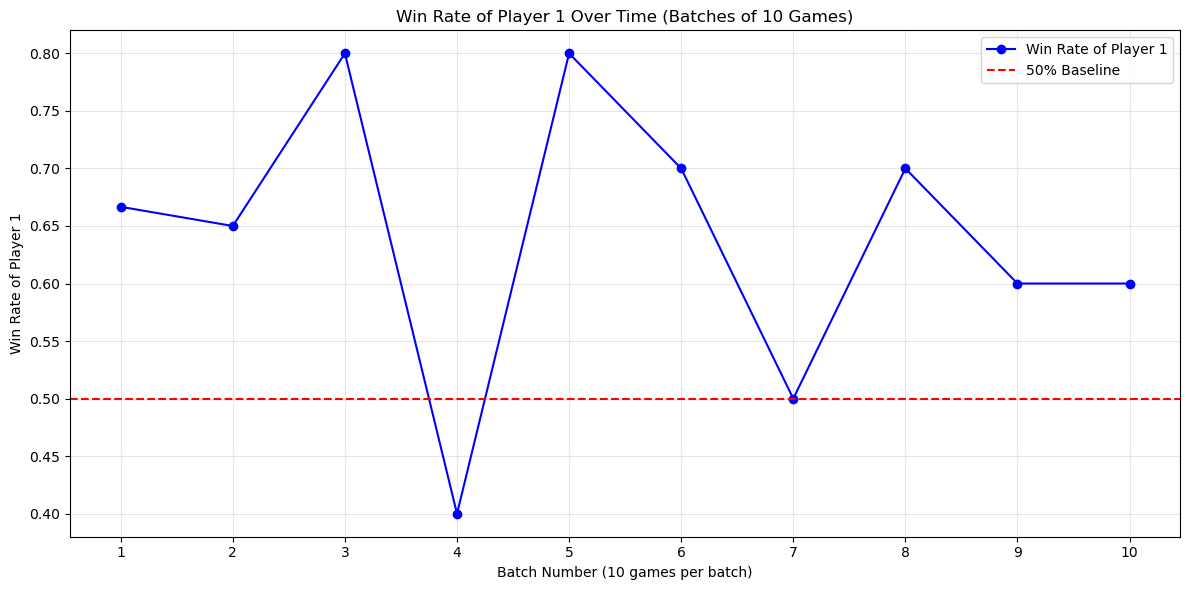

In [ ]:
def analyze_performance(file_path='performance_log.csv', batch_size=10):
    if not os.path.exists(file_path):
        print(f"Arquivo {file_path} não encontrado.")
        return

    # Carregar dados
    data = pd.read_csv(file_path, header=None, names=['game', 'winner'])

    # Agrupar em batches de 'batch_size'
    data['batch'] = (data['game'] - 1) // batch_size

    # Calcular taxa de vitória por batch
    batch_stats = data.groupby('batch')['winner'].apply(lambda x: (x == 1).mean())

    # Plotar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(batch_stats.index + 1, batch_stats.values, marker='o', linestyle='-', color='blue', label='Win Rate of Player 1')
    plt.axhline(y=0.5, color='red', linestyle='--', label='50% Baseline')
    plt.xlabel(f'Batch Number ({batch_size} games per batch)')
    plt.ylabel('Win Rate of Player 1')
    plt.title(f'Win Rate of Player 1 Over Time (Batches of {batch_size} Games)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(range(1, len(batch_stats) + 1))
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_performance()